# Import Libraries

In [10]:
import gym
import numpy as np
import random
import ray
import tensorflow as tf
import utils
from ray.rllib.algorithms.impala import Impala
from ray.rllib.models import ModelCatalog
from ray.rllib.models.tf.tf_modelv2 import TFModelV2

# Define Environment

In [13]:
class MountainCarContinuous(gym.Env):
    def __init__(self, env_config: dict or None = None):
        self._env = gym.make('MountainCarContinuous-v0')

        self.action_space = self._env.action_space
        self.observation_space = self._env.observation_space

    def reset(self) -> np.ndarray:
        return self._env.reset()

    def step(self, action: np.ndarray) -> (np.ndarray, float, bool, dict):
        return self._env.step(action=action)

    def render(self, mode='human'):
        self._env.render()

# Build Default Impala Agent

In [14]:
ray.shutdown()
ray.init()
tf.random.set_seed(seed=0)
np.random.seed(0)
random.seed(0)
agent = Impala(env=MountainCarContinuous, config={
    'env_config': {},
    'model': {'vf_share_layers': True},
    'num_workers': 4,
    'num_envs_per_worker': 1,
    'batch_mode': 'complete_episodes',
    'vtrace': True,
    'vtrace_clip_rho_threshold': 1.0,
    'vtrace_clip_pg_rho_threshold': 1.0,
    'vtrace_drop_last_ts': False,
    'replay_proportion': 0.0,
    'num_sgd_iter': 2,
    'entropy_coeff': 0.01,
    'vf_loss_coeff': 0.5,
    'normalize_actions': True,
    'seed': 0,
    'gamma': 0.99,
    'lr': 0.0005,
    'num_gpus': 1
})
agent.get_policy().model.base_model.summary(expand_nested=True)

2023-04-09 10:49:02,056	INFO worker.py:1518 -- Started a local Ray instance.
(RolloutWorker pid=17688) 2023-04-09 10:49:13,655	WARNING env.py:142 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2023-04-09 10:49:19,379	INFO trainable.py:160 -- Trainable.setup took 14.502 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-04-09 10:49:19,382	WARNING util.py:65 -- Install gputil for GPU system monitoring.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 observations (InputLayer)      [(None, 2)]          0           []                               
                                                                                                  
 fc_1 (Dense)                   (None, 256)          768         ['observations[0][0]']           
                                                                                                  
 fc_2 (Dense)                   (None, 256)          65792       ['fc_1[0][0]']                   
                                                                                                  
 fc_out (Dense)                 (None, 2)            514         ['fc_2[0][0]']                   
                                                                                              

# Training

2023-04-09 10:49:24,623	WARNING deprecation.py:47 -- DeprecationWarning: `concat_samples` has been deprecated. Use `concat_samples() from rllib.policy.sample_batch` instead. This will raise an error in the future!


Iteration: 0, Average Returns: -42.05707392119764
Iteration: 1, Average Returns: -68.39938098094248
Iteration: 2, Average Returns: -49.542381863872585
Iteration: 3, Average Returns: -76.08158388888226
Iteration: 4, Average Returns: -79.66597598703129
Iteration: 5, Average Returns: -85.70348598779395
Iteration: 6, Average Returns: -60.101427164123585
Iteration: 7, Average Returns: -89.74992940589807
Iteration: 8, Average Returns: -92.27855545629774
Iteration: 9, Average Returns: -91.4800310116884
Iteration: 10, Average Returns: -92.7916632787335
Iteration: 11, Average Returns: -74.60626670332371
Iteration: 12, Average Returns: -96.60972638476112
Iteration: 13, Average Returns: -95.9805162409501
Iteration: 14, Average Returns: -96.29086396640264
Iteration: 15, Average Returns: -97.92580771107426
Iteration: 16, Average Returns: -98.09252845744217
Iteration: 17, Average Returns: -97.16451088179585
Iteration: 18, Average Returns: -97.2404756713847
Iteration: 19, Average Returns: -96.2222011

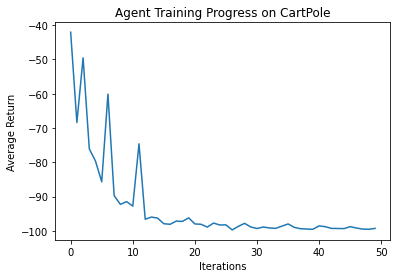

[-42.05707392119764,
 -68.39938098094248,
 -49.542381863872585,
 -76.08158388888226,
 -79.66597598703129,
 -85.70348598779395,
 -60.101427164123585,
 -89.74992940589807,
 -92.27855545629774,
 -91.4800310116884,
 -92.7916632787335,
 -74.60626670332371,
 -96.60972638476112,
 -95.9805162409501,
 -96.29086396640264,
 -97.92580771107426,
 -98.09252845744217,
 -97.16451088179585,
 -97.2404756713847,
 -96.22220110208227,
 -97.98986066167028,
 -98.09187541473757,
 -98.91530509994081,
 -97.72941086377064,
 -98.29956421464303,
 -98.26343319740255,
 -99.73371265837149,
 -98.6857416710215,
 -97.81729848474974,
 -98.88474555994247,
 -99.32415788678378,
 -98.89807455354857,
 -99.15686823409013,
 -99.27927092234536,
 -98.64466689852082,
 -97.99231283582152,
 -98.98905116135784,
 -99.38443112264459,
 -99.48033684218424,
 -99.54117466757951,
 -98.56157661734028,
 -98.79539136960969,
 -99.29726026905928,
 -99.30996261037536,
 -99.35417309786693,
 -98.78597361736803,
 -99.17287009528208,
 -99.48840846784

In [15]:
utils.train(agent=agent, eval_env=MountainCarContinuous(env_config={}))

# Custom Model with Tanh Final (Since Actions=(-1.0, 1.0))

In [16]:
class ImpalaCustomModel(TFModelV2):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        super().__init__(
            obs_space=obs_space,
            action_space=action_space,
            num_outputs=num_outputs,
            model_config=model_config,
            name=name
        )

        inputs = tf.keras.layers.Input(shape=obs_space.shape, name='observations')
        x = tf.keras.layers.Dense(units=256, activation='tanh', name='hidden_1')(inputs)
        x = tf.keras.layers.Dense(units=256, activation='tanh', name='hidden_2')(x)
        policy_out = tf.keras.layers.Dense(units=num_outputs, activation='tanh', name='policy_out')(x)
        value_out = tf.keras.layers.Dense(units=1, name='value_out')(x)
        self.base_model = tf.keras.Model(inputs, [policy_out, value_out])

    def forward(self, input_dict, state, seq_lens):
        model_out, self._value_out = self.base_model(input_dict["obs"])
        return model_out, state

    def value_function(self):
        return tf.reshape(self._value_out, [-1])

# Training Impala with Final Tanh

2023-04-09 11:03:40,095	INFO worker.py:1518 -- Started a local Ray instance.
(RolloutWorker pid=9692) 2023-04-09 11:03:51,077	WARNING env.py:142 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2023-04-09 11:03:55,173	INFO trainable.py:160 -- Trainable.setup took 12.599 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-04-09 11:03:55,177	WARNING util.py:65 -- Install gputil for GPU system monitoring.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 observations (InputLayer)      [(None, 2)]          0           []                               
                                                                                                  
 hidden_1 (Dense)               (None, 256)          768         ['observations[0][0]']           
                                                                                                  
 hidden_2 (Dense)               (None, 256)          65792       ['hidden_1[0][0]']               
                                                                                                  
 policy_out (Dense)             (None, 2)            514         ['hidden_2[0][0]']               
                                                                                              

Exception in thread Thread-115:
Traceback (most recent call last):
  File "C:\Users\Kohli\AppData\Local\Programs\Python\Python39\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "C:\Users\Kohli\AppData\Local\Programs\Python\Python39\lib\site-packages\ray\rllib\execution\learner_thread.py", line 74, in run
    self.step()
  File "C:\Users\Kohli\AppData\Local\Programs\Python\Python39\lib\site-packages\ray\rllib\execution\multi_gpu_learner_thread.py", line 143, in step
    buffer_idx, released = self.ready_tower_stacks_buffer.get()
  File "C:\Users\Kohli\AppData\Local\Programs\Python\Python39\lib\site-packages\ray\rllib\execution\minibatch_buffer.py", line 48, in get
    self.buffers[self.idx] = self.inqueue.get(timeout=self.timeout)
  File "C:\Users\Kohli\AppData\Local\Programs\Python\Python39\lib\queue.py", line 179, in get
    raise Empty
_queue.Empty


Iteration: 1, Average Returns: -43.471037791894055
Iteration: 2, Average Returns: -35.197099526654185
Iteration: 3, Average Returns: -29.686354206674274
Iteration: 4, Average Returns: -23.80339232754921
Iteration: 5, Average Returns: -21.89982421615245
Iteration: 6, Average Returns: -21.668603950598275
Iteration: 7, Average Returns: -20.51711361224622
Iteration: 8, Average Returns: -16.30308594759864
Iteration: 9, Average Returns: -16.592877235397687
Iteration: 10, Average Returns: -14.363640606777114
Iteration: 11, Average Returns: -13.809133474397616
Iteration: 12, Average Returns: -14.651328225665035
Iteration: 13, Average Returns: -14.199005837419914
Iteration: 14, Average Returns: -14.359710513397413
Iteration: 15, Average Returns: -13.679341222112555
Iteration: 16, Average Returns: -13.923901359780615
Iteration: 17, Average Returns: -13.851171213794265
Iteration: 18, Average Returns: -13.675943559026427
Iteration: 19, Average Returns: -13.51627861809873
Iteration: 20, Average Ret

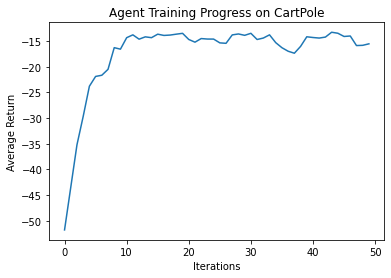

[-51.75335150130045,
 -43.471037791894055,
 -35.197099526654185,
 -29.686354206674274,
 -23.80339232754921,
 -21.89982421615245,
 -21.668603950598275,
 -20.51711361224622,
 -16.30308594759864,
 -16.592877235397687,
 -14.363640606777114,
 -13.809133474397616,
 -14.651328225665035,
 -14.199005837419914,
 -14.359710513397413,
 -13.679341222112555,
 -13.923901359780615,
 -13.851171213794265,
 -13.675943559026427,
 -13.51627861809873,
 -14.710733638003514,
 -15.23339601632857,
 -14.533525917809973,
 -14.62662691765305,
 -14.634238053414805,
 -15.371063154170546,
 -15.456260448497781,
 -13.820367591969788,
 -13.635886916833893,
 -13.902002207399724,
 -13.511819318765777,
 -14.714742567366951,
 -14.433585912532905,
 -13.808372677268324,
 -15.32822336381994,
 -16.312426321127912,
 -16.999138428511923,
 -17.382968512527164,
 -16.055784909398447,
 -14.18540102919319,
 -14.327503283761217,
 -14.435571558512567,
 -14.244321545842942,
 -13.303332411480653,
 -13.496238551104856,
 -14.125934660347422

In [18]:
ray.shutdown()
ray.init()
tf.random.set_seed(seed=0)
np.random.seed(0)
random.seed(0)
ModelCatalog.register_custom_model("impala_model", ImpalaCustomModel)
agent = Impala(env=MountainCarContinuous, config={
    'env_config': {},
    'model': {
        'vf_share_layers': True,
        'custom_model': 'impala_model',
        'custom_model_config': {}
    },
    'num_workers': 4,
    'num_envs_per_worker': 1,
    'batch_mode': 'complete_episodes',
    'vtrace': True,
    'vtrace_clip_rho_threshold': 1.0,
    'vtrace_clip_pg_rho_threshold': 1.0,
    'vtrace_drop_last_ts': False,
    'replay_proportion': 0.0,
    'num_sgd_iter': 2,
    'entropy_coeff': 0.01,
    'vf_loss_coeff': 0.5,
    'normalize_actions': False,
    'seed': 0,
    'gamma': 0.99,
    'lr': 0.0005,
    'num_gpus': 1
})
agent.get_policy().model.base_model.summary(expand_nested=True)
utils.train(agent=agent, eval_env=MountainCarContinuous(env_config={}))